# EDGAR v5 N2O Emissions of Africa for 2015

A quick analysis of the reported N2O emissions for Africa.  

EDGAR data: [source](https://edgar.jrc.ec.europa.eu/overview.php?v=50_GHG)

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import math
import sys
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

module_path = Path.cwd().resolve()
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geo import create_area_grid
# import patched path (contains ls())
from utils.misc import Path

In [3]:
def preprocess_edgar_nc(da, convert_n2o_units=True):
    if convert_n2o_units:
        if da.units == 'kg m-2 s-1':
            da = da * 3600 * 24 * 365 * 10000
            da.attrs['units'] = 'kg ha-1 yr-1'
        else:
            print('unexpected unit - no conversion')

    # also shift dataset from 0...360 longitude to -180...180
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    # make sure we have clean 2 digit lons
    da = da.assign_coords(lon=da.lon.round(2))
    da['lon'].attrs['long_name'] = 'longitude [degrees_east]'
    return da

In [4]:
def simple_plot(da, title=None, robust=True, cmap='viridis', units='kg N ha-1 yr-1'):
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    if title:
        fig.suptitle(title, x=.45, fontsize=16)
    da.plot(ax=ax, robust=robust, cmap=cmap, cbar_kwargs={'label': units})

In [5]:
def multi_plot(das, title=None, robust=True, cmap='viridis', units='kg N ha-1 yr-1'):
    if type(das) != list:
        das = [das]
    
    nplots = len(das)
    if nplots == 1:
        xwidth=5
    elif nplots == 2:
        xwidth=10
    else:
        xwidth=15
        
    fig, ax = plt.subplots(1, nplots, figsize=(xwidth,3))
    if title:
        fig.suptitle(title, x=.45, fontsize=16)
    
    # joined min/ max values (use 2/98 percentile aka xarray robust=True over all datasets) 
    minval = min([x.quantile(0.02) for x in das])
    maxval = max([x.quantile(0.98) for x in das])
    
    for i, da in enumerate(das):
        AX = ax if len(das) == 1 else ax[i]
        das[i].plot(ax=AX, vmin=minval, vmax=maxval, cmap=cmap, cbar_kwargs={'label': units})    

In [30]:
def report_total(da, masks, title):
    totals = []
    for k,v in masks.items():
        total = float((da*v*area).sum()) / 1_000_000
        totals.append(round(total,2))
    
    df = pd.DataFrame({'N2O [Gg N2O yr-1]': totals}, index=['Africa', 'Sub-Sahara', 'Sub-Sahara (dry)'])
    display(df)

In [7]:
data_path = Path('data')

## Load ancillary data
... run preprocessing notebook if these files do not exist!

In [8]:
bioclim = xr.open_dataset("bioclimates.nc")
area = xr.open_dataset("area.nc")['area']

africa = xr.open_dataset('mask.nc')['africa'].where(bioclim.ombro > 0)
subsahara = xr.open_dataset('mask.nc')['subsahara'].where(bioclim.ombro > 0)
subsaharadry = xr.open_dataset('mask.nc')['subsahara'].where(bioclim.dry == 1)

### Domains considered in the analysis:

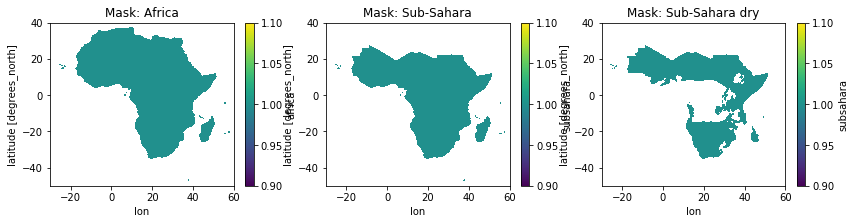

In [9]:
fig, ax = plt.subplots(1, 3 , figsize=(14,3))
africa.plot(ax=ax[0])
subsahara.plot(ax=ax[1])
subsaharadry.plot(ax=ax[2])
ax[0].set_title("Mask: Africa")
ax[1].set_title("Mask: Sub-Sahara")
ax[2].set_title("Mask: Sub-Sahara dry");

In [10]:
masks = {'Africa': africa, 'Sub-Sahara': subsahara, 'Sub-Sahara (dry)': subsaharadry}

## Total N2O emissions

In [14]:
# load data
totaln2o = xr.open_dataset(data_path / 'v50_N2O_2015' / 'v50_N2O_2015.0.1x0.1.nc')['emi_n2o']
totaln2o = preprocess_edgar_nc(totaln2o).sel(lat=slice(-50,40), lon=slice(-30, 60))

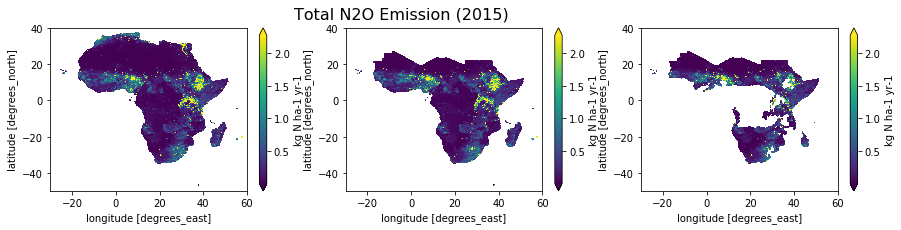

In [15]:
multi_plot([totaln2o*m for m in [africa, subsahara, subsaharadry]], title="Total N2O Emission (2015)")

In [31]:
report_total(totaln2o, masks, "Total annual N2O emission")

,N2O [Gg N2O yr-1]
Africa,973.71
Sub-Sahara,866.41
Sub-Sahara (dry),530.61


## N2O emission - Manure management

In [32]:
manure = xr.open_dataset(data_path / 'v50_N2O_2015_MNM' / 'v50_N2O_2015_MNM.0.1x0.1.nc')['emi_n2o']
manure = preprocess_edgar_nc(manure)

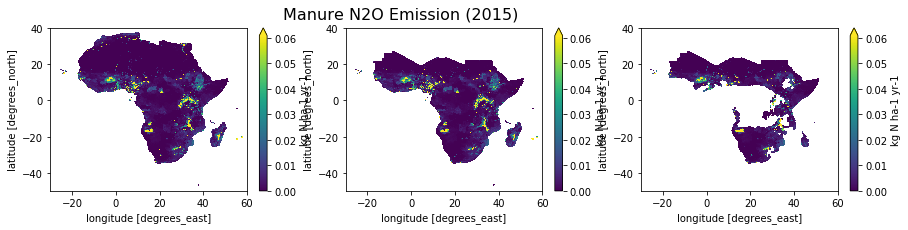

In [37]:
multi_plot([manure*m for m in [africa, subsahara, subsaharadry]], title="Manure N2O Emission (2015)")

In [34]:
report_total(manure, masks, "Annual N2O emission from manure management")

,N2O [Gg N2O yr-1]
Africa,16.96
Sub-Sahara,16.28
Sub-Sahara (dry),7.70


## Agricultural soils

In [35]:
soil = xr.open_dataset(data_path / 'v50_N2O_2015_AGS' / 'v50_N2O_2015_AGS.0.1x0.1.nc')['emi_n2o']
soil = preprocess_edgar_nc(soil)

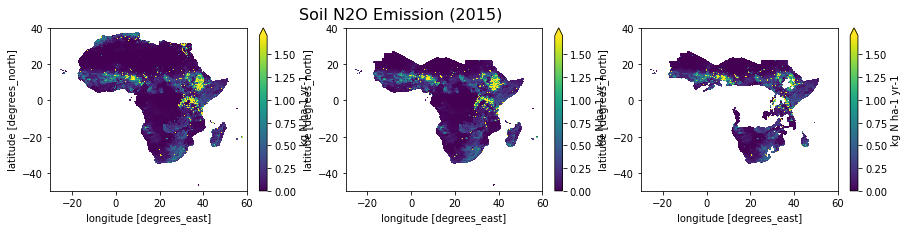

In [38]:
multi_plot([soil*m for m in [africa, subsahara, subsaharadry]], title="Soil N2O Emission (2015)")

In [39]:
report_total(soil, masks, "Annual N2O emission from soil")

,N2O [Gg N2O yr-1]
Africa,682.32
Sub-Sahara,627.07
Sub-Sahara (dry),412.21


## Indirect N2O from agriculture

In [41]:
indirect = xr.open_dataset(data_path / 'v50_N2O_2015_N2O' / 'v50_N2O_2015_N2O.0.1x0.1.nc')['emi_n2o']
indirect = preprocess_edgar_nc(indirect)

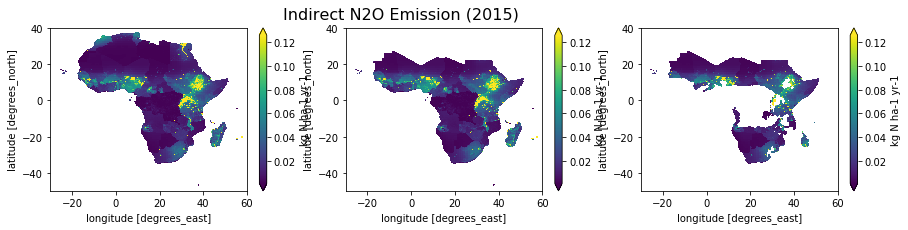

In [42]:
multi_plot([indirect*m for m in [africa, subsahara, subsaharadry]], title="Indirect N2O Emission (2015)")

In [43]:
report_total(indirect, masks, "Indirect N2O emission from agriculture")

,N2O [Gg N2O yr-1]
Africa,69.51
Sub-Sahara,62.13
Sub-Sahara (dry),35.99


## Total N2O from Agriculture

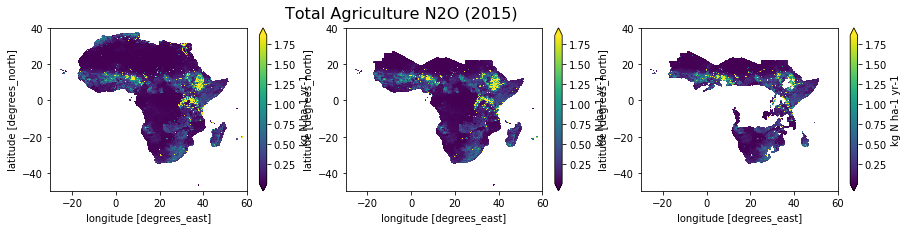

In [44]:
multi_plot([(manure+soil+indirect)*m for m in [africa, subsahara, subsaharadry]], title="Total Agriculture N2O (2015)")

In [45]:
report_total(manure+soil+indirect, masks, "Total N2O emission from agriculture")

,N2O [Gg N2O yr-1]
Africa,768.79
Sub-Sahara,705.48
Sub-Sahara (dry),455.90


## Ratio of total agriculture N2O to total N2O

### Africa

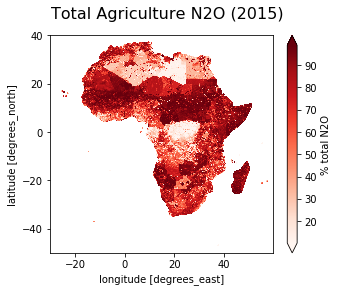

In [34]:
simple_plot(((manure+soil+indirect)/totaln2o)*africa * 100, 
            title="Total Agriculture N2O (2015)",
            units='% total N2O',
            cmap='Reds')

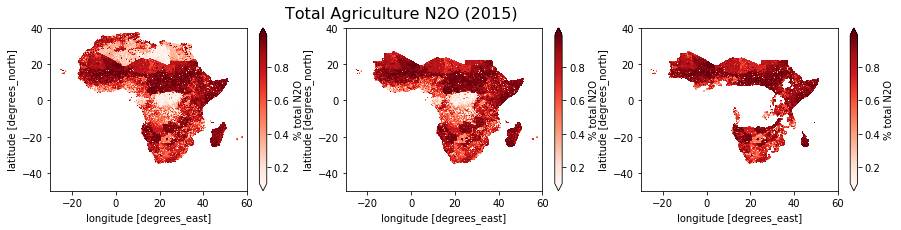

In [46]:
multi_plot([(manure+soil+indirect)/totaln2o*m for m in [africa, subsahara, subsaharadry]], 
           title="Total Agriculture N2O (2015)",
           units='% total N2O',
           cmap='Reds')